In [1]:
!pip install accelerate gradio peft lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 7.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.7/56.7 MB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.8/319.8 kB 16.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.9/94.9 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.0/11.0 MB 48.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.3/73.3 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.2 kB 7.5 MB/s eta 0:00:00
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=0c1f8831445667487b62a9dd7e09a4c82df2fd2f92bb26e6b62dd6a48fd6c213
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime
  Attempting uninstall: markupsafe
    Found

# 仲景基礎對話功能

In [2]:
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch
import gradio as gr

# Set the device
device = "cuda"  # replace with your device: "cpu", "cuda", "mps"

# Initialize model and tokenizer
peft_model_id = "CMLM/ZhongJing-2-1_8b"
base_model_id = "Qwen/Qwen1.5-1.8B-Chat"
model = AutoModelForCausalLM.from_pretrained(base_model_id, device_map="auto")
model.load_adapter(peft_model_id)
tokenizer = AutoTokenizer.from_pretrained(
    "CMLM/ZhongJing-2-1_8b", padding_side="right", trust_remote_code=True, pad_token=""
)

# Initialize conversation history
conversation_history = []

def get_model_response(question):
    global conversation_history

    # Add the new question to the conversation history
    conversation_history.append({"role": "user", "content": question})

    # Prepare the input
    text = tokenizer.apply_chat_template(
        conversation_history, tokenize=False, add_generation_prompt=True
    )
    model_inputs = tokenizer([text], return_tensors="pt").to(device)

    # Generate the response
    generated_ids = model.generate(model_inputs.input_ids, max_new_tokens=512)
    generated_ids = [
        output_ids[len(input_ids) :]
        for input_ids, output_ids in zip(model_inputs.input_ids, generated_ids)
    ]

    # Decode the response
    response = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]

    # Add the model's response to the conversation history
    conversation_history.append({"role": "assistant", "content": response})

    return response

# Define a Gradio interface with multi-turn conversation
def chat_interface(question):
    response = get_model_response(question)
    return response

iface = gr.Interface(
    fn=chat_interface,
    inputs=["text"],
    outputs="text",
    title="仲景GPT-V2-1.8B",
    description="博极医源，精勤不倦。Unlocking the Wisdom of Traditional Chinese Medicine with AI.",
)

# Launch the interface with sharing enabled
# iface.launch(share=True)
iface.launch()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/662 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.67G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/206 [00:00<?, ?B/s]

adapter_config.json:   0%|          | 0.00/596 [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/6.30M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.19k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/3.38M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/80.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/367 [00:00<?, ?B/s]

Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://1e8d9c08aee69ecf8f.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


# LIME 手動中文空格分詞版本

In [2]:
from lime.lime_text import LimeTextExplainer
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch
import numpy as np

# 加載模型和分詞器
peft_model_id = "CMLM/ZhongJing-2-1_8b"
base_model_id = "Qwen/Qwen1.5-1.8B-Chat"
model = AutoModelForCausalLM.from_pretrained(base_model_id, device_map="auto")
model.load_adapter(peft_model_id)
tokenizer = AutoTokenizer.from_pretrained(
    "CMLM/ZhongJing-2-1_8b", padding_side="right", trust_remote_code=True, pad_token=""
)


def predictor(texts):
    results = []
    for text in texts:
        # 創建消息格式
        messages = [
            {"role": "system", "content": "You are a helpful medical assistant."},
            {"role": "user", "content": text},
        ]

        # 準備輸入
        formatted_text = tokenizer.apply_chat_template(
            messages, tokenize=False, add_generation_prompt=True
        )
        inputs = tokenizer([formatted_text], return_tensors="pt").to(model.device)

        with torch.no_grad():
            # 獲取模型輸出
            outputs = model(**inputs)
            logits = outputs.logits

            # 計算最後一個token的概率分布
            probs = torch.softmax(logits[0, -1], dim=-1)

            # 取前兩個最高概率
            top_probs = torch.topk(probs, 2)
            prob_array = np.array(
                [top_probs.values[0].item(), top_probs.values[1].item()]
            )

            # 標準化概率
            prob_array = prob_array / prob_array.sum()
            results.append(prob_array)

    return np.array(results)


# 創建解釋器
explainer = LimeTextExplainer(
    class_names=["中医相关", "非中医相关"],
    split_expression=lambda x: x.split(),  # 使用空格分詞
    bow=True,
    random_state=42,
)

# 測試文本（使用中文）
test_text = "喉咙痛 的 中医 疗法"

# 生成解釋
explanation = explainer.explain_instance(
    text_instance=test_text,
    classifier_fn=predictor,
    num_features=10,
    num_samples=1000,
    top_labels=1,
)

# 顯示解釋結果
print("\n=== 詞語重要性分析 ===")
for word, importance in explanation.as_list(label=0):
    print(f"詞語: {word:<20} 影響度: {importance:.4f}")

# 生成HTML可視化
html = explanation.as_html()
with open("zhongjing_explanation.html", "w", encoding="utf-8") as f:
    f.write(html)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/662 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.67G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/206 [00:00<?, ?B/s]

adapter_config.json:   0%|          | 0.00/596 [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/6.30M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.19k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/3.38M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/80.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/367 [00:00<?, ?B/s]


=== 詞語重要性分析 ===
詞語: 中医                   影響度: -0.2146
詞語: 的                    影響度: 0.0333
詞語: 喉咙痛                  影響度: 0.0321
詞語: 疗法                   影響度: -0.0281


# LIME - jieba 中文自動分词版本

In [2]:
from lime.lime_text import LimeTextExplainer
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch
import numpy as np
import jieba

device = "cuda"

# 加載模型和分詞器
peft_model_id = "CMLM/ZhongJing-2-1_8b"
base_model_id = "Qwen/Qwen1.5-1.8B-Chat"
model = AutoModelForCausalLM.from_pretrained(base_model_id, device_map="auto")
model.load_adapter(peft_model_id)
tokenizer = AutoTokenizer.from_pretrained(
    "CMLM/ZhongJing-2-1_8b", padding_side="right", trust_remote_code=True, pad_token=""
)

# Initialize conversation history
conversation_history = []

def get_model_response(question):
    global conversation_history

    # 将新问题添加到对话历史中
    conversation_history.append({"role": "user", "content": question})

    # Prepare the input
    text = tokenizer.apply_chat_template(
        conversation_history, tokenize=False, add_generation_prompt=True
    )
    model_inputs = tokenizer([text], return_tensors="pt").to(device)

    # Generate the response
    generated_ids = model.generate(model_inputs.input_ids, max_new_tokens=512)
    generated_ids = [
        output_ids[len(input_ids) :]
        for input_ids, output_ids in zip(model_inputs.input_ids, generated_ids)
    ]

    # Decode the response
    response = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]

    # 将模型的回复添加到对话历史中
    conversation_history.append({"role": "assistant", "content": response})

    return response

def predictor(texts):
    results = []
    for text in texts:
        # 創建消息格式
        messages = [
            {"role": "system", "content": "You are a helpful medical assistant."},
            {"role": "user", "content": text},
        ]

        # 準備輸入
        formatted_text = tokenizer.apply_chat_template(
            messages, tokenize=False, add_generation_prompt=True
        )
        inputs = tokenizer([formatted_text], return_tensors="pt").to(model.device)

        with torch.no_grad():
            outputs = model(**inputs)
            logits = outputs.logits
            probs = torch.softmax(logits[0, -1], dim=-1)
            top_probs = torch.topk(probs, 2)
            prob_array = np.array(
                [top_probs.values[0].item(), top_probs.values[1].item()]
            )
            prob_array = prob_array / prob_array.sum()
            results.append(prob_array)

    return np.array(results)


# 自定義分詞函數
def chinese_tokenizer(text):
    return list(jieba.cut(text, cut_all=False))


# 創建解釋器
explainer = LimeTextExplainer(
    class_names=["症状诊断相关", "症状诊断不相关"],
    split_expression=chinese_tokenizer,  # 使用jieba分詞
    bow=True,
    random_state=42,
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/662 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.67G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/206 [00:00<?, ?B/s]

adapter_config.json:   0%|          | 0.00/596 [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/6.30M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.19k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/3.38M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/80.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/367 [00:00<?, ?B/s]

In [3]:
import textwrap


# 基本用法
def wrap_text(text, width=70):
    # 使用textwrap.fill()直接返回換行後的文本字符串
    wrapped_text = textwrap.fill(text, width=width)
    return wrapped_text


# 更多自定義選項的用法
def wrap_text_advanced(text, width=70, initial_indent="", subsequent_indent="  "):
    wrapper = textwrap.TextWrapper(
        width=width,  # 每行最大寬度
        initial_indent=initial_indent,  # 第一行縮進
        subsequent_indent=subsequent_indent,  # 後續行縮進
        break_long_words=True,  # 允許斷開長單詞
        break_on_hyphens=True,  # 允許在連字符處斷行
    )
    wrapped_text = wrapper.fill(text)
    return wrapped_text


# 示例文本
text = "这是一段很长的中文文本，需要进行自动换行处理。通过使用Python的textwrap模块，我们可以轻松实现文本的自动换行功能，使得输出的文本更加整齐美观。"

# 基本換行
print("基本換行示例：")
print(wrap_text(text, width=20))

print("\n高級換行示例：")
print(wrap_text_advanced(text, width=20, initial_indent="    ", subsequent_indent="  "))

基本換行示例：
这是一段很长的中文文本，需要进行自动换行
处理。通过使用Python的textwr
ap模块，我们可以轻松实现文本的自动换行
功能，使得输出的文本更加整齐美观。

高級換行示例：
    这是一段很长的中文文本，需要进行
  自动换行处理。通过使用Python的
  textwrap模块，我们可以轻松实
  现文本的自动换行功能，使得输出的文本
  更加整齐美观。


In [4]:
print("\n=== 病人提問 ===")
# 測試文本
test_text = "张某，男，27岁。患者因昨晚饮酒发热，喝凉水数杯，早晨腹痛腹泻，大便如水色黄，腹中辘辘有声，恶心欲吐，胸中满闷不舒，口干欲冷饮，舌质红、苔白腻，脉沉细数。给出中医诊断和处方建议。"
print(wrap_text((test_text), width=30))


# 模型結果
print("\n=== 模型結果 ===")
response = get_model_response(test_text)
print(wrap_text(response, width=30))

# 生成解釋
explanation = explainer.explain_instance(
    text_instance=test_text,
    classifier_fn=predictor,
    num_features=len(chinese_tokenizer(test_text)),
    num_samples=1500,
    top_labels=1,
)

# 顯示解釋結果
print("\n=== 詞語重要性分析 ===")
for word, importance in explanation.as_list(label=0):
    print(f"詞語: {word:<20} 影響度: {importance:.4f}")

The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.



=== 病人提問 ===
张某，男，27岁。患者因昨晚饮酒发热，喝凉水数杯，早晨腹痛腹
泻，大便如水色黄，腹中辘辘有声，恶心欲吐，胸中满闷不舒，口干
欲冷饮，舌质红、苔白腻，脉沉细数。给出中医诊断和处方建议。

=== 模型結果 ===


Building prefix dict from the default dictionary ...
DEBUG:jieba:Building prefix dict from the default dictionary ...


中医诊断：伤食泻，湿热蕴肠证。 处方建议：
1、选用藿香正气散加减治疗。 2、可服用止泻灵口服液等益生菌
调节肠道菌群，帮助恢复正常消化功能。
注意：本方需在医生指导下应用。


Dumping model to file cache /tmp/jieba.cache
DEBUG:jieba:Dumping model to file cache /tmp/jieba.cache
Loading model cost 1.809 seconds.
DEBUG:jieba:Loading model cost 1.809 seconds.
Prefix dict has been built successfully.
DEBUG:jieba:Prefix dict has been built successfully.



=== 詞語重要性分析 ===
詞語: 中医                   影響度: -0.0912
詞語: 和                    影響度: 0.0242
詞語: 如                    影響度: 0.0231
詞語: 给出                   影響度: 0.0158
詞語: 黄                    影響度: -0.0134
詞語: 细数                   影響度: 0.0125
詞語: 腹泻                   影響度: 0.0119
詞語: 早晨                   影響度: -0.0108
詞語: 数杯                   影響度: 0.0099
詞語: 处方                   影響度: -0.0096
詞語: 发热                   影響度: -0.0086
詞語: 水色                   影響度: -0.0072
詞語: 凉水                   影響度: 0.0071
詞語: 建议                   影響度: -0.0068
詞語: 恶心                   影響度: -0.0054
詞語: 岁                    影響度: 0.0054
詞語: 诊断                   影響度: 0.0052
詞語: 27                   影響度: 0.0051
詞語: 辘辘                   影響度: -0.0046
詞語: 红                    影響度: -0.0045
詞語: ，                    影響度: 0.0044
詞語: 张某                   影響度: -0.0041
詞語: 腹中                   影響度: -0.0036
詞語: 腹痛                   影響度: -0.0036
詞語: 饮酒                   影響度: -0.0034
詞語: 舌质                   影響度: -0.0033
詞語: 胸中

<ipython-input-8-c6562e18bbad>:35: UserWarning: Glyph 24433 (\N{CJK UNIFIED IDEOGRAPH-5F71}) missing from current font.
  plt.tight_layout()
<ipython-input-8-c6562e18bbad>:35: UserWarning: Glyph 38911 (\N{CJK UNIFIED IDEOGRAPH-97FF}) missing from current font.
  plt.tight_layout()
<ipython-input-8-c6562e18bbad>:35: UserWarning: Glyph 24230 (\N{CJK UNIFIED IDEOGRAPH-5EA6}) missing from current font.
  plt.tight_layout()
<ipython-input-8-c6562e18bbad>:35: UserWarning: Glyph 20013 (\N{CJK UNIFIED IDEOGRAPH-4E2D}) missing from current font.
  plt.tight_layout()
<ipython-input-8-c6562e18bbad>:35: UserWarning: Glyph 21307 (\N{CJK UNIFIED IDEOGRAPH-533B}) missing from current font.
  plt.tight_layout()
<ipython-input-8-c6562e18bbad>:35: UserWarning: Glyph 40644 (\N{CJK UNIFIED IDEOGRAPH-9EC4}) missing from current font.
  plt.tight_layout()
<ipython-input-8-c6562e18bbad>:35: UserWarning: Glyph 26089 (\N{CJK UNIFIED IDEOGRAPH-65E9}) missing from current font.
  plt.tight_layout()
<ipython-inpu

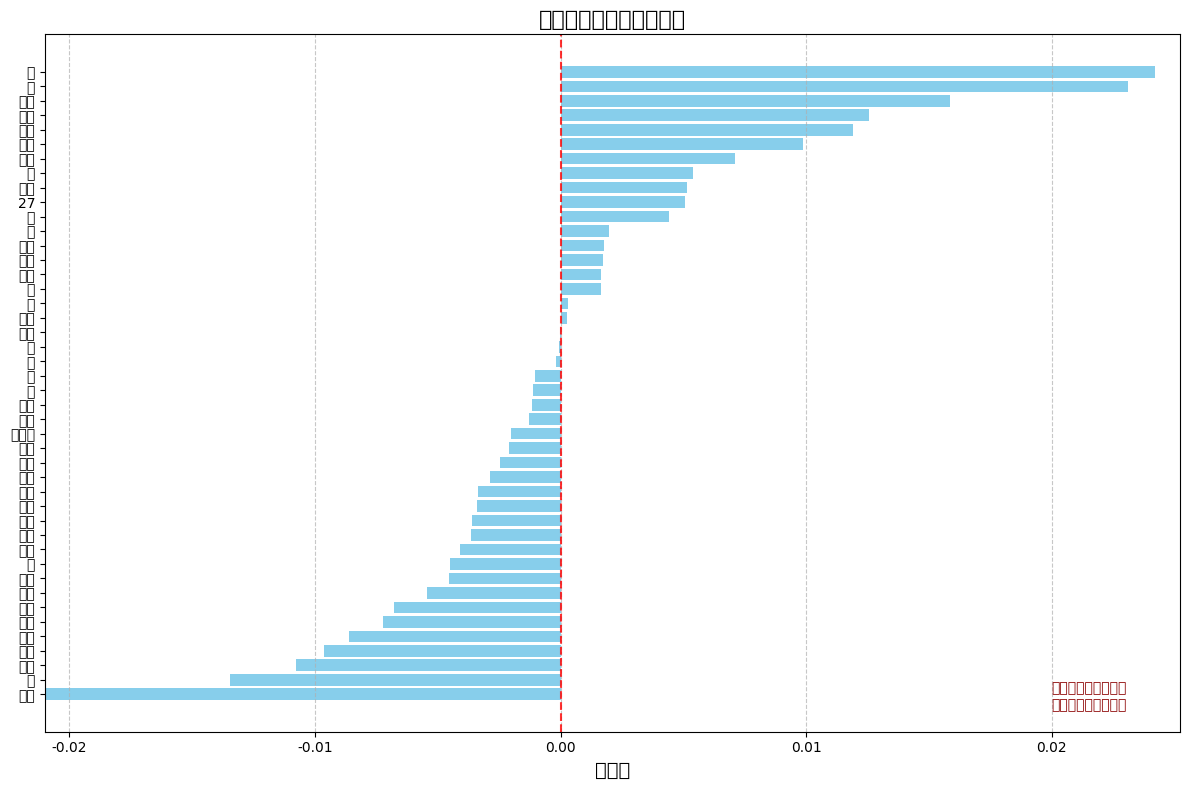

In [8]:
import matplotlib.pyplot as plt
import pandas as pd

# 設置全局字體為黑體
plt.rcParams["font.family"] = ["Noto Serif CJK JP"]
plt.rcParams["axes.unicode_minus"] = False

# 從explanation獲取結果並創建數據框
words_importance = explanation.as_list(label=0)
df = pd.DataFrame(words_importance, columns=["詞語", "影響度"])

# 按影響度排序
df = df.sort_values("影響度", ascending=True)

# 創建水平條形圖
plt.figure(figsize=(12, 8))
plt.barh(df["詞語"], df["影響度"], color="skyblue")

# 設置標題和標籤
plt.title("中醫診斷詞語重要性分析", fontsize=16)
plt.xlabel("影響度", fontsize=14)

# 添加參考線
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.axvline(x=0, color="red", linestyle="--", alpha=0.8)

# 添加註釋
plt.text(
    0.02, -1, "正值表示增加相關性\n負值表示降低相關性", fontsize=10, color="darkred"
)

# 調整布局
plt.xlim(-0.02 - 0.001, max(df["影響度"]) + 0.001)  # 右側留些空間

plt.tight_layout()

# 保存圖片
# plt.savefig("lime_analysis.png", dpi=300, bbox_inches="tight")

# 顯示圖表
plt.show()